# Importing required library

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import random as ran
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T

Populating the interactive namespace from numpy and matplotlib


# GPU Availability

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No cuda available")
print(f"Used device is {device}")

Used device is cuda:0


# Import dataset

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=T.ToTensor())

In [8]:
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


In [7]:
print(mnist_trainset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [9]:
print(f"Train set size : {mnist_trainset.data.size()}")
print(f"Train set size : {mnist_testset.data.size()}")
print(f"The number of classes : {len(mnist_testset.classes)}")

Train set size : torch.Size([60000, 28, 28])
Train set size : torch.Size([10000, 28, 28])
The number of classes : 10


# Print one train data

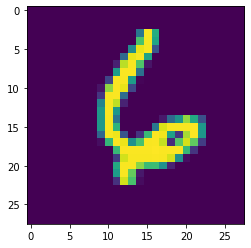

In [10]:
plt.imshow(mnist_trainset.data[59000])
plt.show()

# Data Loader

In [11]:
train_dl = torch.utils.data.DataLoader(mnist_trainset, batch_size = 100)
test_dl = torch.utils.data.DataLoader(mnist_testset, batch_size = 100)

# Creating Model

In [12]:
def create_LeNet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding = 2),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.MaxPool2d(2, stride = 2),
        nn.Conv2d(6, 16, 5, padding = 0),
        nn.Dropout(p = 0.2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

# Validation of the model

In [13]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct * 100 / total

# Training Function

In [14]:
def train(numb_epoch, lr = 1e-3, device = 'cpu'):
    accuracies = []
    accuracies_log = {}
    cnn = create_LeNet().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr = lr)
    max_accuracy = 0
    for epoch in range (numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_function(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, test_dl))
        accuracies.append(accuracy)
        accuracies_log[epoch] = accuracy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_model = cnn
            print(f"Saving Best Model with accuracy {accuracy}")
        print(f"Epoch : {epoch + 1} / {numb_epoch + 1}, Accuracy : {accuracy}")
    plt.plot(accuracies)
    return best_model, accuracies_log

Saving Best Model with accuracy 95.70999908447266
Epoch : 1 / 11, Accuracy : 95.70999908447266
Saving Best Model with accuracy 96.94999694824219
Epoch : 2 / 11, Accuracy : 96.94999694824219
Saving Best Model with accuracy 97.33000183105469
Epoch : 3 / 11, Accuracy : 97.33000183105469
Saving Best Model with accuracy 98.11000061035156
Epoch : 4 / 11, Accuracy : 98.11000061035156
Saving Best Model with accuracy 98.22000122070312
Epoch : 5 / 11, Accuracy : 98.22000122070312
Saving Best Model with accuracy 98.45999908447266
Epoch : 6 / 11, Accuracy : 98.45999908447266
Saving Best Model with accuracy 98.56999969482422
Epoch : 7 / 11, Accuracy : 98.56999969482422
Epoch : 8 / 11, Accuracy : 98.5199966430664
Saving Best Model with accuracy 98.83999633789062
Epoch : 9 / 11, Accuracy : 98.83999633789062
Epoch : 10 / 11, Accuracy : 98.69000244140625


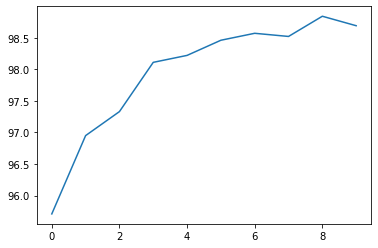

In [12]:
lenet, accuracies_log = train(10, device=device)

# Creating 2nd Model

In [15]:
def train(numb_epoch, lr = 1e-3, device = 'cuda:0'):
    train_accuracies = []
    train_accuracies_log = {}
    cnn = create_LeNet().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr = lr)
    max_accuracy = 0
    for epoch in range (numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_function(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, train_dl))
        train_accuracies.append(accuracy)
        train_accuracies_log[epoch] = accuracy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_model = cnn
            print(f"Saving Best Model in train case with accuracy {accuracy}")
        if epoch % 5 == 0 :
            print(f"Epoch : {epoch + 1} / {numb_epoch + 1}, Accuracy : {accuracy}")
    
    print("TEST CASE")
    test_accuracies = []
    test_accuracies_log = {}
    for epoch in range (numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_function(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, test_dl))
        test_accuracies.append(accuracy)
        test_accuracies_log[epoch] = accuracy
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_model = cnn
            print(f"Saving Best Model in test case with accuracy {accuracy}")
        if epoch % 5 == 0 :
            print(f"Epoch : {epoch + 1} / {numb_epoch + 1}, Accuracy : {accuracy}")
    plt.plot(train_accuracies, color = 'r', label = 'Train')
    plt.plot(test_accuracies, color = 'g', label = 'Test')
    plt.legend()
    plt.show()
    return best_model, train_accuracies_log, test_accuracies_log

Saving Best Model in train case with accuracy 94.79166412353516
Epoch : 1 / 101, Accuracy : 94.79166412353516
Saving Best Model in train case with accuracy 96.94833374023438
Saving Best Model in train case with accuracy 97.59666442871094
Saving Best Model in train case with accuracy 98.17166900634766
Saving Best Model in train case with accuracy 98.33833312988281
Saving Best Model in train case with accuracy 98.5616683959961
Epoch : 6 / 101, Accuracy : 98.5616683959961
Saving Best Model in train case with accuracy 98.84833526611328
Saving Best Model in train case with accuracy 98.97833251953125
Saving Best Model in train case with accuracy 99.05000305175781
Epoch : 11 / 101, Accuracy : 99.05000305175781
Saving Best Model in train case with accuracy 99.10166931152344
Saving Best Model in train case with accuracy 99.12666320800781
Saving Best Model in train case with accuracy 99.32499694824219
Epoch : 16 / 101, Accuracy : 99.25833129882812
Saving Best Model in train case with accuracy 99

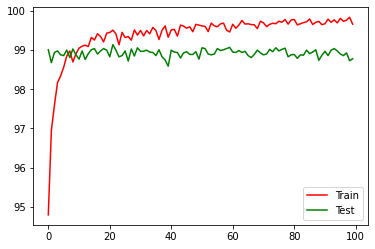

In [16]:
lenet, train_accuracies_log, test_accuracies_log = train(100, device=device)